In [1]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from numpy import linalg as LA
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import SparsePauliOp
from qiskit.quantum_info.operators import Operator
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit, transpile
from IPython.display import clear_output
from tqdm import trange
from scipy.optimize import minimize
import numpy.random as nrd

# modified from TFIM_OICD_noisy.ipynb

# generate Hamiltonian

we consider the transverse-field Ising model,

$$
H=J \sum_{j=1}^{N-1} Z_j Z_{j+1}+\Delta \sum_{j=1}^N X_j
$$

with the coefficient $J=1$ and $\Delta=1.5$. Here $N$ denotes the number of qubits, and $X_j, Z_j$ are Pauli operators acting on the $j$-th qubit.


In [2]:
num_q = 8 ##

# parameters for setting up the Hamiltonian
J = 1
Delta = 1.5

# set H1
List_1 = []
for i in range(num_q-1):
    op = ""
    for k in range(i): # I's before ZZ
        op += "I"
    op += "ZZ"
    for k in range(i+1,num_q-1): # I's after ZZ
        op += "I"
    List_1.append(op)

List_1.reverse()

# example:
# for num_q = 5, List_1 = ['IIIZZ', 'IIZZI', 'IZZII', 'ZZIII']

H1 = SparsePauliOp(List_1, J*np.ones(num_q-1))  

# set H2
List_2 = []
for i in range(num_q):
    op = ""
    for k in range(i):
        op += "I"
    op += "X"
    for k in range(i+1,num_q):
        op += "I"
    List_2.append(op)
    
H2 = SparsePauliOp(List_2, Delta*np.ones(num_q))

# set H = H1 + H2
H = SparsePauliOp.sum([H1,H2])
Hmat = Operator(H)
Hmat = Hmat.data # This is the matrix representation of the Hamiltonian
# Ordering in SparsePauliOp e.g. IIIIIIZZ is the measurement of Z gates on the first 
# two qubits and so forth.

e, v = LA.eig(Hmat) # Compute the eigenvalues and right eigenvectors of a square array.
min_index = np.argmin(e)
v_min = v[:,min_index] # ground state (eigenvector)
ground_e = np.min(e) # ground state energy

# print(H[-1])
print(ground_e)
print(H.size)
print(H)

(-13.191404952188934+0j)
15
SparsePauliOp(['IIIIIIZZ', 'IIIIIZZI', 'IIIIZZII', 'IIIZZIII', 'IIZZIIII', 'IZZIIIII', 'ZZIIIIII', 'XIIIIIII', 'IXIIIIII', 'IIXIIIII', 'IIIXIIII', 'IIIIXIII', 'IIIIIXII', 'IIIIIIXI', 'IIIIIIIX'],
              coeffs=[1. +0.j, 1. +0.j, 1. +0.j, 1. +0.j, 1. +0.j, 1. +0.j, 1. +0.j, 1.5+0.j,
 1.5+0.j, 1.5+0.j, 1.5+0.j, 1.5+0.j, 1.5+0.j, 1.5+0.j, 1.5+0.j])


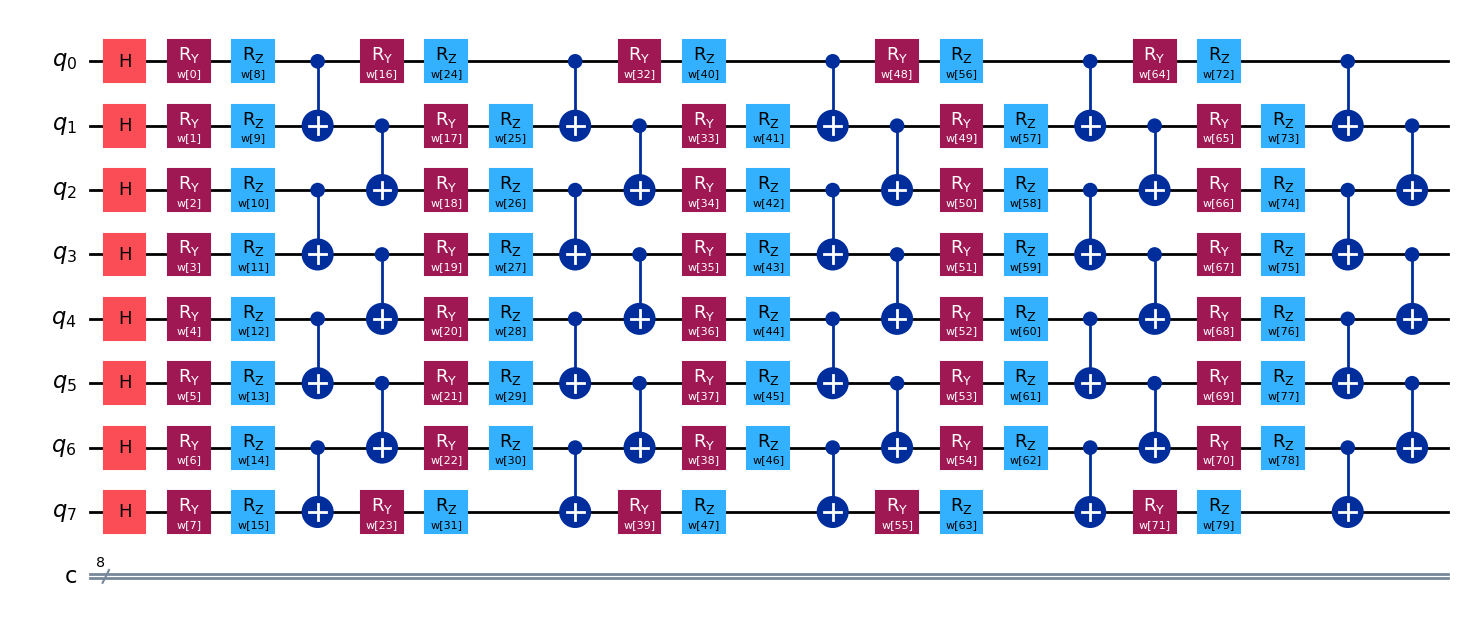

In [3]:
"""circuit construction"""
layer = 6 ##

num_p = layer* 2*num_q

weights = ParameterVector("w",num_p)

def circuit_ex(weights):
    circ = QuantumCircuit(num_q, num_q)

    for j in range(num_q):
        circ.h(j)

    for i in range(layer):

        for j in range(num_q):
            circ.ry(weights[2*i*num_q+j],j)
        for j in range(num_q):
            circ.rz(weights[2*i*num_q+num_q+j],j)


        for j in range(int(num_q/2)):
            circ.cx(2*j,2*j+1)
        for j in range(int(num_q/2)-1):
            circ.cx(2*j+1,2*j+2)
    return circ

qc=circuit_ex(weights)
qc.draw('mpl')


In [4]:
simulator = AerSimulator()

def estimate_loss(WEIGHTS, SHOTS):

    # estimate for ZZ gates in H1
    estimate = 0
    qc = circuit_ex(WEIGHTS)
    qc = transpile(qc, simulator)
    ind = list(range(num_q))
    rind = ind
    rind.reverse()
    qc.measure(ind, rind)
    result = simulator.run(qc, shots = SHOTS, memory=True).result()
    c = result.get_memory(qc) 

    for i in range(SHOTS):
        c_i = c[i]

        for j in range(num_q-1):
            if c_i[num_q-1-j] == c_i[num_q-1-(j+1)]:
                estimate += 1
            else:
                estimate += -1

    estimate = J*estimate/SHOTS
    

    # estimate_1 for X gates in H2
    estimate_1 = 0
    qc = circuit_ex(WEIGHTS)
    for i in range(num_q):
        qc.h(i)
    qc = transpile(qc, simulator)
    ind = list(range(num_q))
    rind = ind
    rind.reverse()
    qc.measure(ind, rind)
    result = simulator.run(qc, shots = SHOTS, memory=True).result()
    c = result.get_memory(qc)
    for i in range(SHOTS):
        c_i = c[i]
        for j in range(num_q):
            if c_i[num_q-1-j] == '0':
                estimate_1 += 1
            else:
                estimate_1 += -1

    estimate_1 = Delta*estimate_1/SHOTS
    
    return estimate + estimate_1



def expectation_loss(WEIGHTS):
    qc = circuit_ex(WEIGHTS)
    qc.save_statevector()
    qc = transpile(qc, simulator)
    result = simulator.run(qc).result()
    state_vector = result.get_statevector(qc)
    psi = np.asarray(state_vector)
    # ==========================================================================
    Hpsi = Hmat.dot(psi)
    expectation = np.inner(np.conjugate(psi),Hpsi)
    return np.real(expectation)

def fidelity(WEIGHTS):
    qc = circuit_ex(WEIGHTS)
    qc.save_statevector()
    qc = transpile(qc, simulator)
    result = simulator.run(qc).result()
    state_vector = result.get_statevector(qc)
    psi = np.asarray(state_vector)
    # ==========================================================================
    return np.absolute(np.vdot(psi,v_min))**2

def std(WEIGHTS):
    qc = circuit_ex(WEIGHTS)
    qc.save_statevector()
    qc = transpile(qc, simulator)
    result = simulator.run(qc).result()
    state_vector = result.get_statevector(qc)
    psi = np.asarray(state_vector)
    # ==========================================================================
    Hmat_sqaured =  Hmat @ Hmat
    Hmat_sqauredpsi = Hmat_sqaured.dot(psi)
    var = np.inner(np.conjugate(psi),Hmat_sqauredpsi) - expectation_loss(WEIGHTS)**2
    return np.sqrt(np.real(var))


In [5]:
weights = np.random.uniform(0, 2*np.pi, size=num_p)

print(expectation_loss(weights))
print(std(weights))
print(expectation_loss(weights)/std(weights))

shots = 1000
if False:
    true_value = expectation_loss(weights)

    num_trials = 1000
    estimate_results = [estimate_loss(weights, shots) for _ in range(num_trials)]

    plt.figure(figsize=(10, 6))
    plt.hist(estimate_results, bins=30, density=True, alpha=0.6, color='g', label='Estimation Results')
    plt.axvline(true_value, color='r', linestyle='--', label=f'True Value = {true_value}')
    plt.title('Distribution of estimate_Z outputs')
    plt.xlabel('Estimated Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    plt.show()

    


0.1556070105231197
5.2941503312744
0.0293922538625121


In [6]:
from check_utils import interp_matrix

weights_dict = {}

omegas = [1]
interp_nodes = np.linspace(0,2*np.pi,2*len(omegas)+1,endpoint=False)
# interp_nodes = np.random.uniform(0, 2*np.pi, size=2*len(omegas)+1)
inverse_interp_matrix = np.linalg.inv(interp_matrix(interp_nodes, omegas))

for i in range(num_p):
    weights_dict[f'weights_{i}'] = {
        'omegas': omegas,
        'interp_nodes': interp_nodes,
        'inverse_interp_matrix': inverse_interp_matrix,
    }

print(weights_dict['weights_0'])
print(f'true ground state energy:',ground_e)

{'omegas': [1], 'interp_nodes': array([0.       , 2.0943951, 4.1887902]), 'inverse_interp_matrix': array([[ 4.71404521e-01,  4.71404521e-01,  4.71404521e-01],
       [ 6.66666667e-01, -3.33333333e-01, -3.33333333e-01],
       [-1.92296269e-16,  5.77350269e-01, -5.77350269e-01]])}
true ground state energy: (-13.191404952188934+0j)


In [7]:
# Verify if the function can be accurately interpolated by trigonometric interpolation based on omegas

from check_utils import check_is_trigometric  # Assuming check_is_trigometric is defined in check_utils module

# Define random weights
weights = np.random.normal(0, 4 * np.pi**2, num_p)

# Loop over each weight index and check trigonometric interpolation
for j in range(num_p//10):
    # Circuit_HEA is simple and all Hermitian generators are Y.
    omegas = weights_dict[f'weights_{j}']['omegas']  # This needs to be determined based on the circuit (i.e., parameters to test interpolation)
    
    print('\n index to check = ', j)
    print('omegas = ', omegas)
    
    opt_interp_flag = False  # Flag to indicate if optimal interpolation should be used
    
    # Call the function to check if the objective function can be interpolated using trigonometric interpolation
    check_is_trigometric(expectation_loss, j, omegas, weights, opt_interp_flag)




 index to check =  0
omegas =  [1]
Consistent results: 100/100
【All Passed】
Estimated coefficients:  [ 0.240425    0.31711518 -0.44993441]

 index to check =  1
omegas =  [1]
Consistent results: 100/100
【All Passed】
Estimated coefficients:  [ 0.19353369 -0.17760757 -0.46031964]

 index to check =  2
omegas =  [1]
Consistent results: 100/100
【All Passed】
Estimated coefficients:  [ 0.19266033 -0.17273051  0.72813809]

 index to check =  3
omegas =  [1]
Consistent results: 100/100
【All Passed】
Estimated coefficients:  [0.24665691 0.04915906 0.73008629]

 index to check =  4
omegas =  [1]
Consistent results: 100/100
【All Passed】
Estimated coefficients:  [-0.78453632 -0.02158259 -0.04046926]

 index to check =  5
omegas =  [1]
Consistent results: 100/100
【All Passed】
Estimated coefficients:  [-0.4079137 -0.1094873 -0.234814 ]

 index to check =  6
omegas =  [1]
Consistent results: 100/100
【All Passed】
Estimated coefficients:  [-0.53875051 -0.02355004  0.20781484]

 index to check =  7
omeg

In [8]:
"""optimization phase"""
mat = scipy.io.loadmat('w0')
w0 = mat['w0']
initial_weights = np.zeros(num_p) #np.ones(num_p)
initial_weights[:10] = w0.flatten()
# initial_weights = np.random.uniform(0, 2*np.pi, size=num_p)

n_shot = 1000

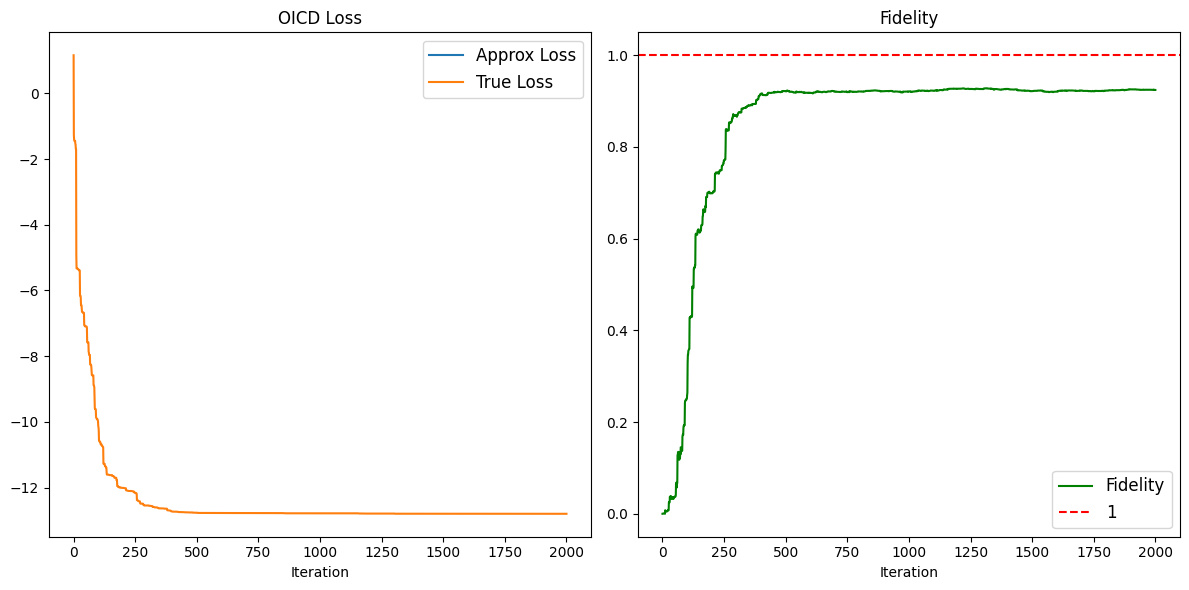

[OICD] Iter: 1999 - Coord: 19(80), Best loss: -12.799838650448896, True loss: -12.776866784216294, Fidelity: 0.9242962452750441: 100%|██████████| 2000/2000 [16:04<00:00,  2.07it/s]


In [9]:
# OICD Optimization
from algo.oicd_qiskit import oicd

num_iter = 2000
# Run OICD
final_weights_oicd, best_expected_record_value_oicd, fidelity_record_value_oicd, func_oicd = oicd(
    estimate_loss,
    expectation_loss,
    fidelity,
    n_shot, weights_dict, initial_weights, num_iter,
    subproblem_method='CG',  # https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html
    subproblem_iter=None,
    cyclic_mode=False,
    use_local_solvers_flag=False,
    use_pratical_interp_flag=True,
    exact_mode=False,
    plot_flag=True,
)


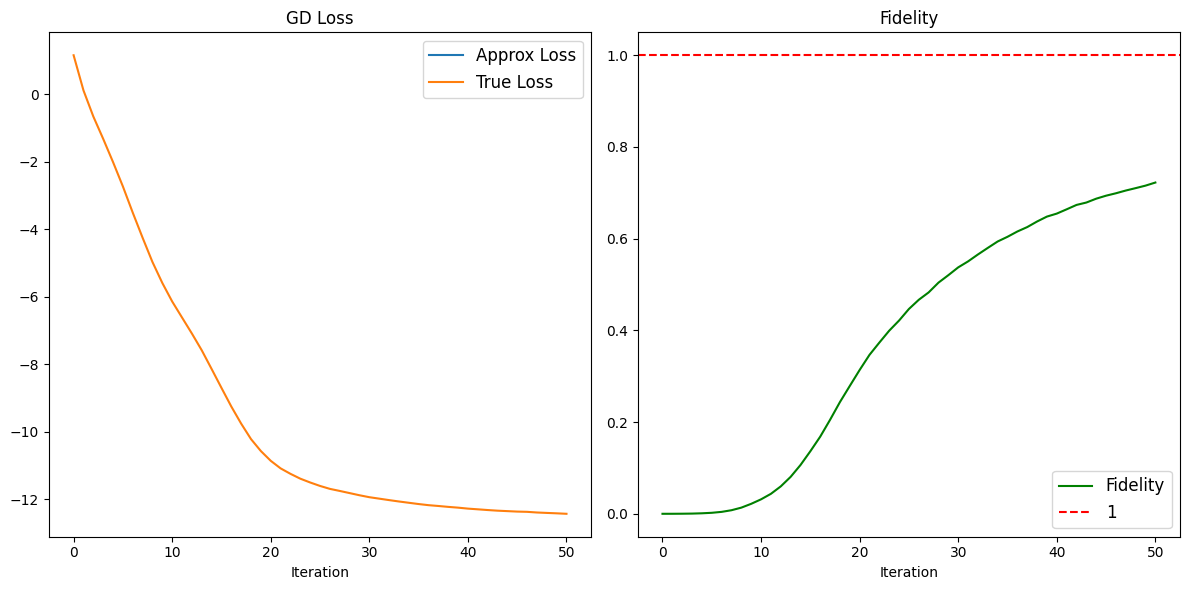

[GD] Iter: 49, Best loss: -12.4366871932809, True loss: -12.4366871932809, Fidelity: 0.7224409675526987: 100%|██████████| 50/50 [11:52<00:00, 14.25s/it]


In [10]:

# Gradient Descent Optimization
from algo.gd_qiskit import gd

num_iter = 50
# Run GD
final_weights_gd, best_expected_record_value_gd, fidelity_record_value_gd, func_gd = gd(
    estimate_loss,
    expectation_loss,
    fidelity,
    n_shot, weights_dict, initial_weights, num_iter,
    learning_rate=0.05,
    exact_mode=False,
    plot_flag=True,
)


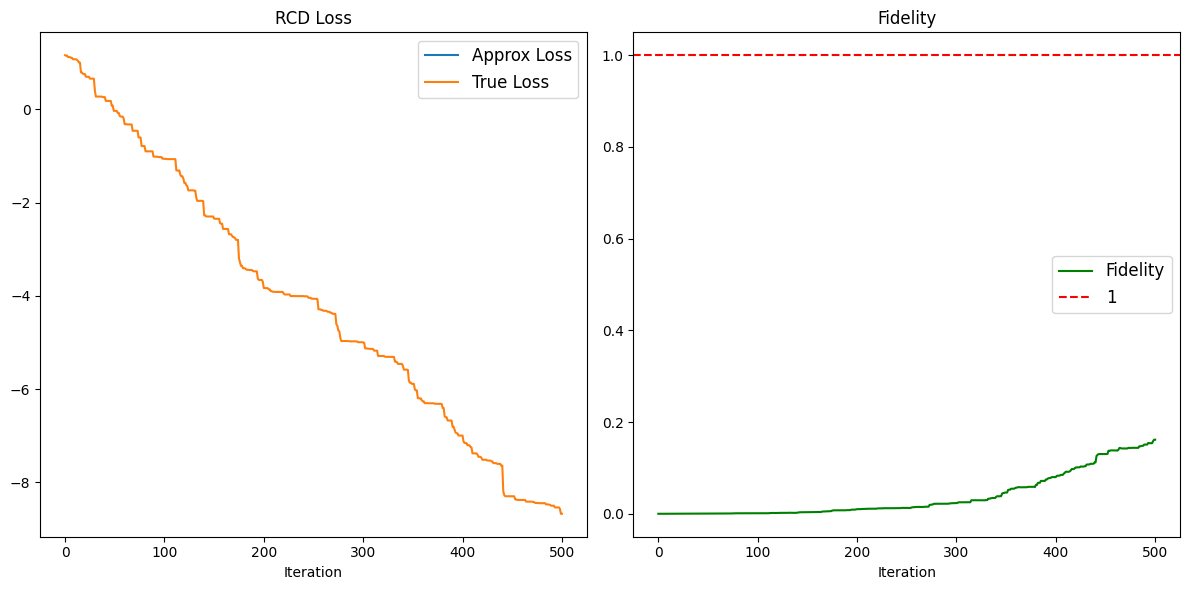

[RCD] Iter: 499, Best loss: -8.67384304918714, True loss: -8.673768424222448, Fidelity: 0.16171601475819603: 100%|██████████| 500/500 [04:26<00:00,  1.88it/s]


In [11]:

# RCD Optimization
from algo.rcd_qiskit import rcd

num_iter = 500
# Run RCD
final_weights_rcd, best_expected_record_value_rcd, fidelity_record_value_rcd, func_rcd= rcd(
    estimate_loss,
    expectation_loss,
    fidelity,
    n_shot, weights_dict, initial_weights, num_iter,
    learning_rate=0.1,
    cyclic_mode=False,
    exact_mode=False,
    plot_flag=True,
)


c:\ProgramData\anaconda3\envs\RCD\lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


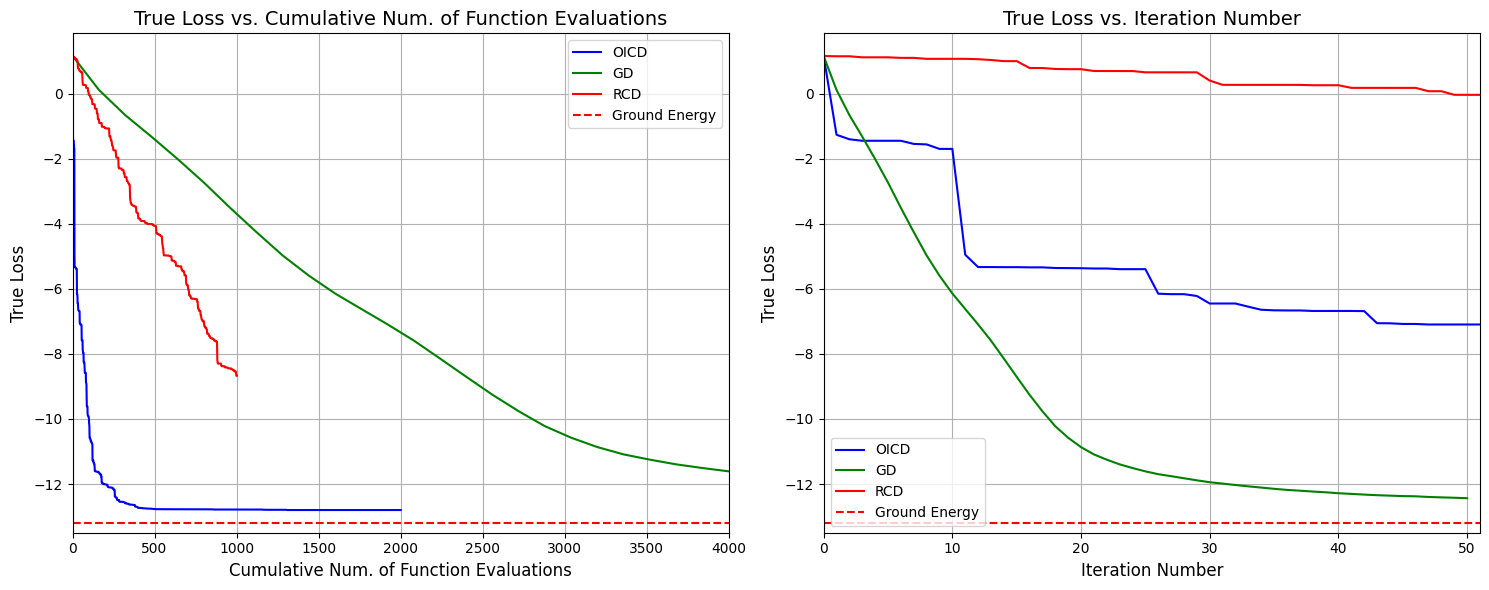

In [12]:
# Create a 1x2 subplot layout
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# First subplot: x-axis is the cumulative number of function evaluations, y-axis is the function value
axs[0].plot(func_oicd, best_expected_record_value_oicd, label='OICD', color='blue')
axs[0].plot(func_gd, best_expected_record_value_gd, label='GD', color='green')
axs[0].plot(func_rcd, best_expected_record_value_rcd, label='RCD', color='red')
axs[0].axhline(y=ground_e, color='r', linestyle='--', label='Ground Energy')

# Set labels and title for the first subplot
axs[0].set_xlabel('Cumulative Num. of Function Evaluations', fontsize=12)
axs[0].set_ylabel('True Loss', fontsize=12)
axs[0].set_title('True Loss vs. Cumulative Num. of Function Evaluations', fontsize=14)

# Set the x-axis range
# x_range = np.average([func_oicd[-1], func_gd[-1], func_rcd[-1]])
# x_range = max(func_oicd[-1], func_gd[-1], func_rcd[-1])
# x_range = min(func_oicd[-1], func_gd[-1], func_rcd[-1])
x_range = func_oicd[-1]*1
axs[0].set_xlim(0, x_range)

# Display the legend for the first subplot
axs[0].legend()

# Second subplot: x-axis is the iteration number, y-axis is the function value
axs[1].plot(best_expected_record_value_oicd, label='OICD', color='blue')
axs[1].plot(best_expected_record_value_gd, label='GD', color='green')
axs[1].plot(best_expected_record_value_rcd, label='RCD', color='red')
axs[1].axhline(y=ground_e, color='r', linestyle='--', label='Ground Energy')

# Set labels and title for the second subplot
axs[1].set_xlabel('Iteration Number', fontsize=12)
axs[1].set_ylabel('True Loss', fontsize=12)
axs[1].set_title('True Loss vs. Iteration Number', fontsize=14)

# Set the x-axis range
axs[1].set_xlim(0, min(len(best_expected_record_value_oicd), len(best_expected_record_value_gd), len(best_expected_record_value_rcd)))

# Display the legend for the second subplot
axs[1].legend()

# Display grid lines
for ax in axs:
    ax.grid(True)

# Adjust the layout automatically to avoid overlapping labels between subplots
plt.tight_layout()

# Show the plot
plt.show()


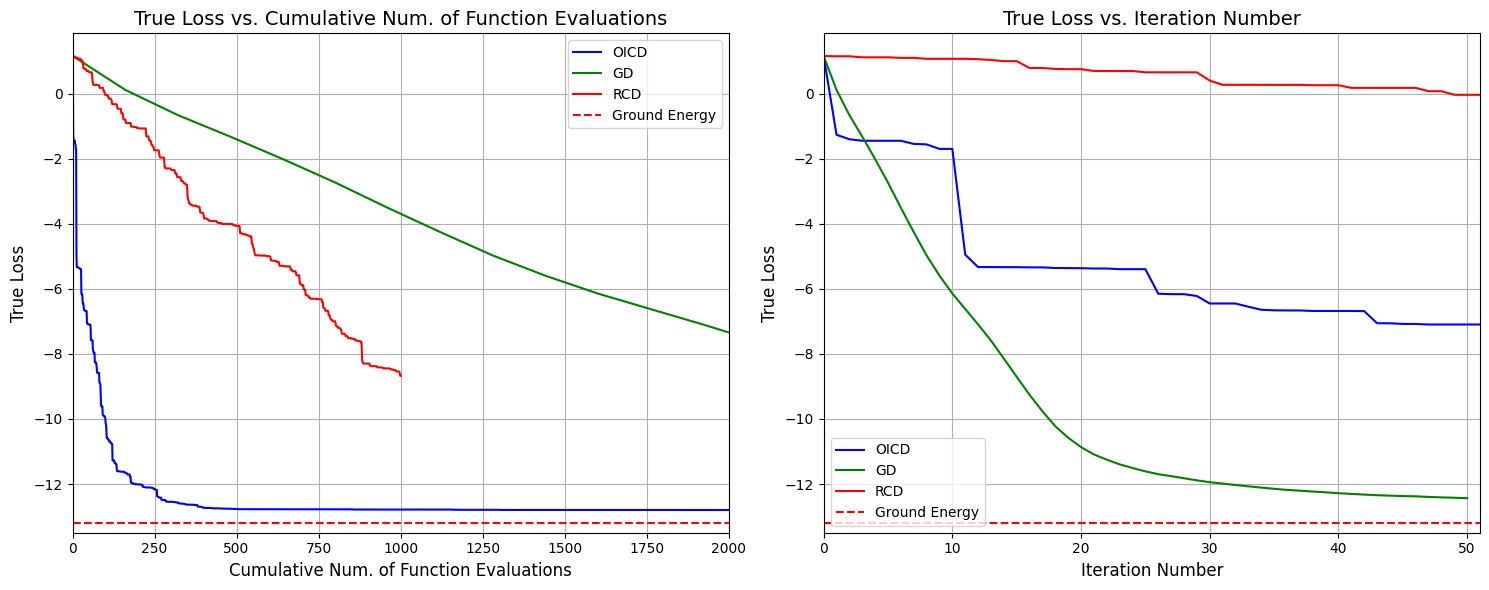

In [14]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# First subplot: x-axis is the cumulative number of function evaluations, y-axis is Fidelity
axs[0].plot(func_oicd, fidelity_record_value_oicd, label='OICD', color='blue')
axs[0].plot(func_gd, fidelity_record_value_gd, label='GD', color='green')
axs[0].plot(func_rcd, fidelity_record_value_rcd, label='RCD', color='red')
axs[0].axhline(y=1, color='r', linestyle='--', label='1')

# Set labels and title for the first subplot
axs[0].set_xlabel('Cumulative Num. of Function Evaluations', fontsize=12)
axs[0].set_ylabel('Fidelity', fontsize=12)
axs[0].set_title('Fidelity vs. Cumulative Num. of Function Evaluations', fontsize=14)

# Set the x-axis range
# x_range = np.average([func_oicd[-1], func_gd[-1], func_rcd[-1]])
# x_range = max(func_oicd[-1], func_gd[-1], func_rcd[-1])
# x_range = min(func_oicd[-1], func_gd[-1], func_rcd[-1])
x_range = func_oicd[-1]*2
axs[0].set_xlim(0, x_range)

# Display the legend for the first subplot
axs[0].legend()

# Second subplot: x-axis is the iteration number, y-axis is Fidelity
axs[1].plot(fidelity_record_value_oicd, label='OICD', color='blue')
axs[1].plot(fidelity_record_value_gd, label='GD', color='green')
axs[1].plot(fidelity_record_value_rcd, label='RCD', color='red')
axs[1].axhline(y=1, color='r', linestyle='--', label='1')

# Set labels and title for the second subplot
axs[1].set_xlabel('Iteration Number', fontsize=12)
axs[1].set_ylabel('Fidelity', fontsize=12)
axs[1].set_title('Fidelity vs. Iteration Number', fontsize=14)

# Set the x-axis range
axs[1].set_xlim(0, min(len(fidelity_record_value_oicd), len(fidelity_record_value_gd), len(fidelity_record_value_rcd)))

# Display the legend for the second subplot
axs[1].legend()

# Display grid lines
for ax in axs:
    ax.grid(True)

# Automatically adjust layout to avoid overlap
plt.tight_layout()

# Display the plot
plt.show()
